# < 10. CIFAR-10 이미지 생성하기 >

## [루브릭]
1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.

## <mark>[GAN 이란]</mark>
- Generative Adversarial Network , 생성 모델
- <mark>생성자(Generator)</mark>  :  아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성해 낸다. 즉, 무에서 유를 창조하는 것과 같은 역할을 한다
- <mark>판별자(Discriminator)</mark> : 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real인지 , Fake 인지에 대한 판단 정도를 실숫값으로 출력
    - Generative Model : 위조지폐를 만들어내는 팀
    - Discriminative Model : 위조 지폐범을 잡아내는 경찰
    - 위조지폐를 만들어내는 팀은 잡히지 않기 위해 더 진짜 같은 지폐를 만들려고 하며, 그것을 잡아내려는 경찰은 끊임없이 진짜 지폐와 위조지폐를 구분하려고 한다. 즉, 서로 간의 경쟁이 둘 모두를 성장하게 한다. 궁극적인 목표는 진짜 지폐와 구분될 수 없는 위조지폐를 만들어 내는 것이다.
![](https://d3s0tskafalll9.cloudfront.net/media/images/GAN.max-800x600.png)


---

## Step1. 필요한 모듈 import

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import random as python_random
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import os


# 밑에 코드는 조원분들이랑 결과를 비교하기 위해 랜덤시드값을 맞춰준 거다 
os.environ["PYTHONHASHSEED"] = "1234"
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

---

## Step2. 데이터셋 구성
- CIRAR-10
    - airplane
    - automobile
    - bird
    - cat
    - deer
    - dog
    - frog
    - horse
    - ship
    - truck

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


### 정규화

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


### 시각화

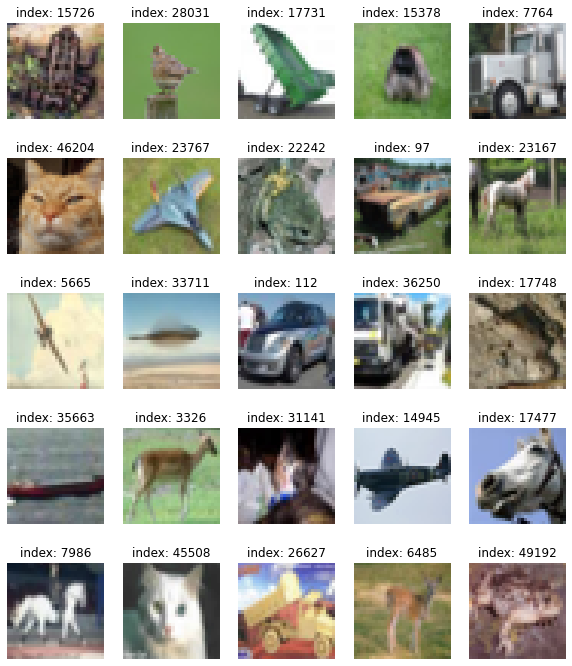

In [5]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index].reshape(32, 32, 3) +1) / 2.0)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

### 미니배치

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128 #256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- BUFFER_SIZE : 전체 데이터를 섞기 위해 50000으로 설정
- BATCH_SIZE : 모델이 한 번에 학습할 데이터의 양
    - 너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행한다

---

## Step3. 생성자 모델 구현하기

In [7]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

#### <mark>Conv2DTranspose </mark>
- 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다
- 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키워나간다
- 여기서 최종 사이즈인 (28, 28, 1)은 우리가 준비했던 데이터셋과 형상이 동일
| Conv 타입 | 연산 | 0 삽입 | 패딩 |  스트라이드 | 아웃풋 사이즈 |
| --------- | ---- | ------ | ---- | ---------- | ---------- |
| 일반적 | 다운 샘플링(size 감소) | 0 | p | s | (i+2p-k) / s + 1 |
| Transposed | 업 샘플링(size 증가) | s-1 | k-p+1 | 1 | (i-1)* s + k - 2p |
- https://velog.io/@hayaseleu/Transposed-Convolutional-Layer%EC%9D%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80

#### <mark>BatchNormalization</mark>
- 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜준다

#### <mark>LeakyReLU</mark>
- ReLU와 동일하나 x < 0 인 값에 대해서 0.01을 곱하여 ReLU함수의 단점을 보완

#### <mark>tanh</mark>
- -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함

In [8]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### 확인

In [9]:
noise = tf.random.normal([1, 100])

In [10]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

---

## Step4. 판별자 모델 구현

In [11]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

#### <mark>make_discriminator_model()</mark>
- 판별자는 Conv2D층으로 이미지의 크기를 점점 줄여나간다
- 첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 된다
- 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환
    - 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할
-  1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 된다

In [12]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [13]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00018481]], dtype=float32)>

---

## Step5. 손실함수와 최적화 함수 구현하기

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### generator_loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy

In [17]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수(optimizer)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### 확인

In [19]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

---

## Step6. 훈련과정 상세 기능 구현
<mark>train_step</mark> : 한 단계를 학습 <br>
<mark>generate_and_save_images()</mark> : 샘플 이미지를 생성하고 저장 <br>
<mark>draw_train_history()</mark> : 학습 과정을 시각화 <br>
<mark>checkpoint</mark> : 모델 저장

In [20]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

#### <mark>train_step()</mark>
1. 입력 데어터 : Real Image 역할을 할 images 한 세트를 입력으로 받음
2. 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
3. tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
4. generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
5. discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
6. loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
7.  accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산

8. gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
9.  모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
10. 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

#### 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수

In [21]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    predictions = (predictions + 1) / 2.0
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

####  loss와 accuracy 그래프

In [22]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

#### chekpoint
- 정기적으로 모델을 저장하기 위해서
- <code>tf.train.Checkpoint</code>를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다
-  optimizer와 생성자, 판별자를 모두 넣어 저장

In [23]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---

## Step7. 학습 과정 진행하기

In [24]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### <font color="blue">(1) EPOCHS=200</font>

In [25]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

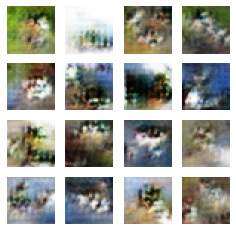

Time for training : 3496 sec


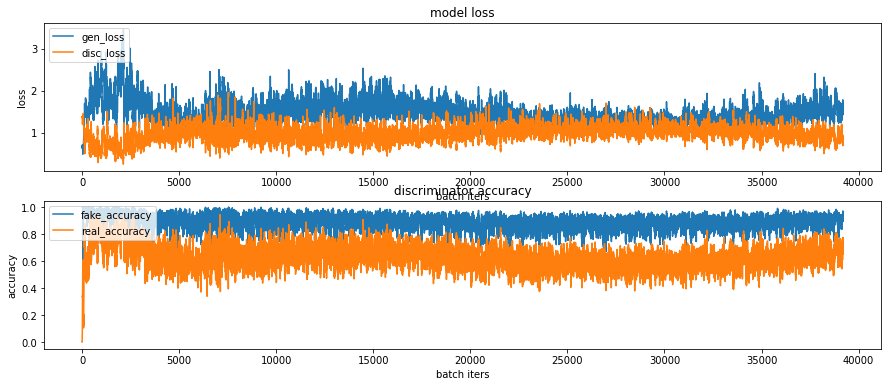

CPU times: user 59min 47s, sys: 5min 21s, total: 1h 5min 8s
Wall time: 58min 18s


In [26]:
%%time
train(train_dataset, EPOCHS, save_every)

> 200epoch일때 학습이 덜 되어 이미지를 아예 알아볼 수 없다

In [27]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1090670 Feb  8 07:47 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


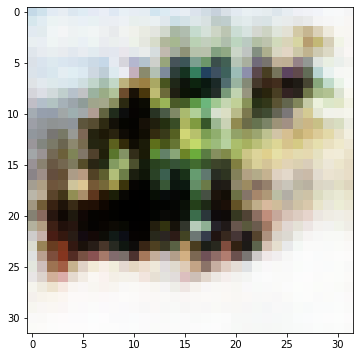

In [28]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

![](https://blog.kakaocdn.net/dn/ydMiI/btrsSuGCDgk/uDwMwJA5v2I4DOrQRRQqSK/img.gif)

### <font color="blue">(2) EPOCHS=500</font>

In [53]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

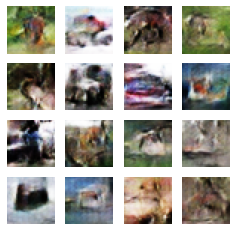

Time for training : 9335 sec


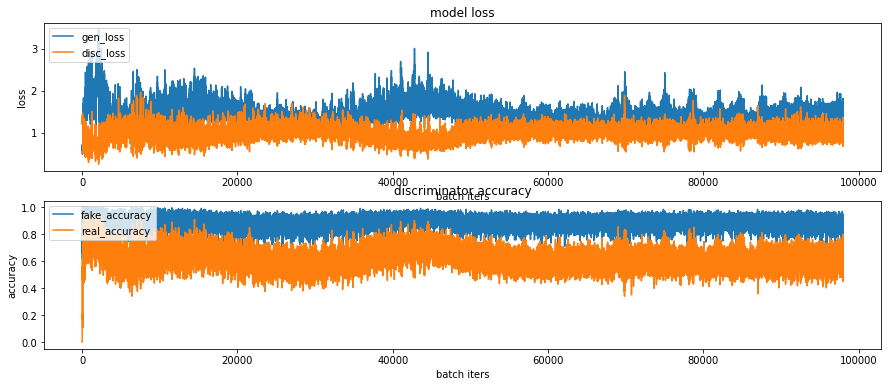

CPU times: user 2h 39min 5s, sys: 13min 22s, total: 2h 52min 28s
Wall time: 2h 35min 41s


In [54]:
%%time
train(train_dataset, EPOCHS, save_every)

> 500epoch일때 200epoch 보다 형체가 생긴것 같고 개구리처럼 보이는 이미지가 생성되고 있는 것 같다 <br>
> 1000epoch까지 추가적으로 진행했을 때 이미지가 향상되지 않아서 400-300epoch를 사용하기로 했다 

In [55]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1090670 Feb  8 07:47 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


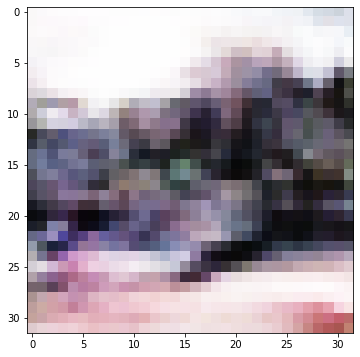

In [56]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

![](https://blog.kakaocdn.net/dn/ekE12U/btrsMWRMfWO/IGWudK2ddDHBZChBd52XL1/img.gif)

### <font color="blue">(3) learning rate 증가</font>
- 기존 0.0001에서 0.0003으로 증가시켰다

In [25]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)

# 학습 횟수 및 저장간격 설정
save_every = 5
EPOCHS = 400

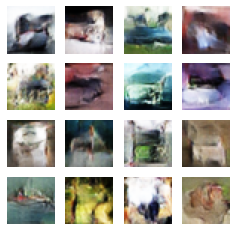

Time for training : 7284 sec


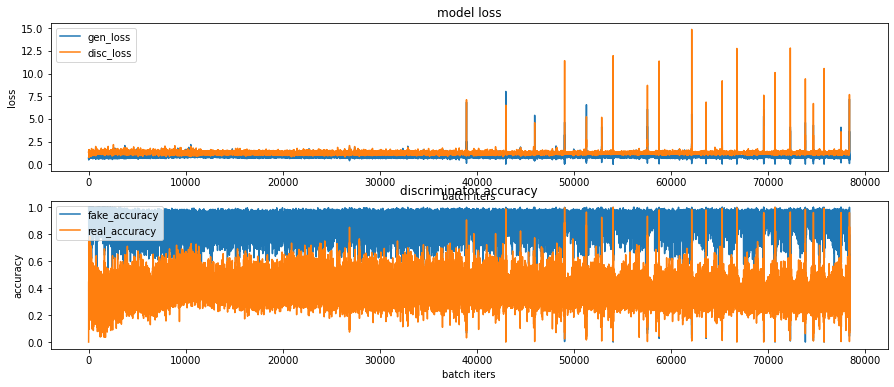

CPU times: user 2h 4min 2s, sys: 10min 29s, total: 2h 14min 32s
Wall time: 2h 1min 28s


In [26]:
%%time
train(train_dataset, EPOCHS, save_every)

### <font color="blue">(4) SGD</font>

In [18]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=2e-3)

In [25]:
# 학습 횟수 및 저장간격 설정
save_every = 5
EPOCHS = 300

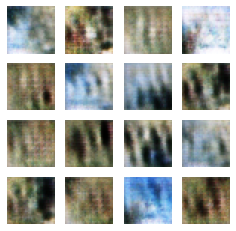

Time for training : 6503 sec


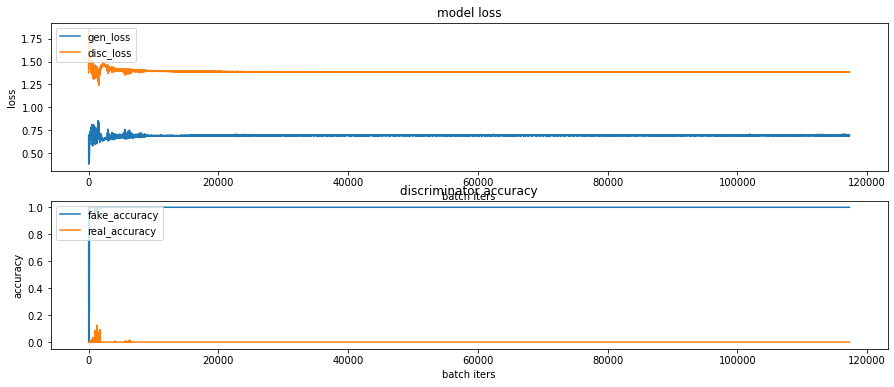

CPU times: user 1h 54min 14s, sys: 11min 48s, total: 2h 6min 2s
Wall time: 1h 48min 29s


In [26]:
%%time
train(train_dataset, EPOCHS, save_every)

> discriminator의 최적화 함수를 SGD를 사용하면 좋다는걸 보고 바꾸어 봤는데 생성된 이미지도 이상하고 그래프를 보면 fake accuracy가 1인데 이는 판별자가 매우 쉽게 판별하고 있다는 뜻이다. <br>
하이퍼파라미터값을 잘못 설정한것 같다

### <font color="blue">(5) 드롭아웃(0.2)추가</font>
- 생성자 모델에 드롭아웃 레이어를 추가했다

In [30]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [31]:
generator = make_generator_model()

generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)        

In [29]:
save_every = 5
EPOCHS = 400

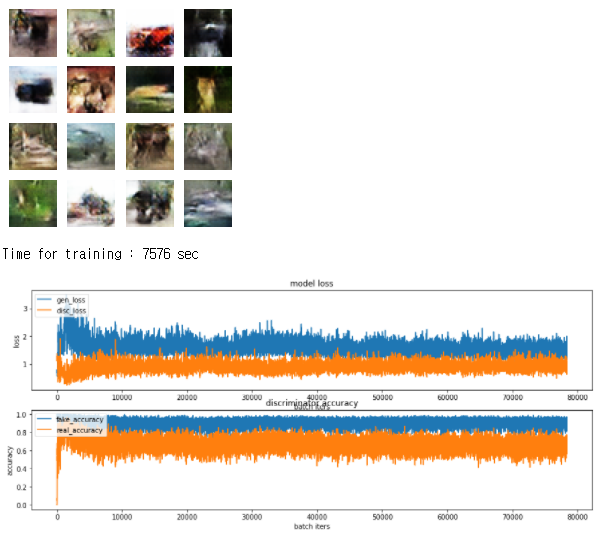

> dropout을 적용했더니 개체를 어느 정도 판단할 수 있는 이미지가 있다 <br>
세번째 이미지는 자동차, 11번째 이미지는 말처럼 보인다

### <font color="blue">(6) 배치사이즈128/드롭아웃(0.5)</font>

In [32]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [33]:
save_every = 5
EPOCHS = 400

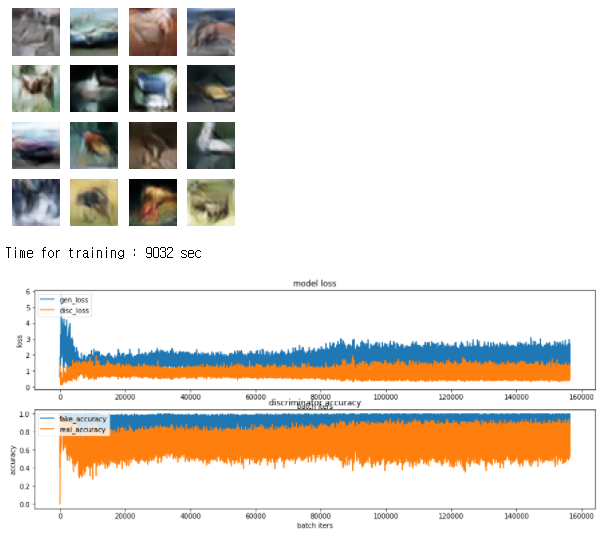

> 드롭아웃 비율을 0.5로 했는데 학습에 절반의 뉴런을 사용하지 않는거라 에폭을 늘렸어야 했다 <br>
드롭아웃을 적용했더니 이미지가 물 많이 먹은 물감처럼 흐려진 것 같다

### <font color="blue">(7) 레이어추가 밑 파라미터 증가</font>
- generator, discriminator의 레이어를 추가시켜서 더 깊은 network를 만들었고, 채널을 늘렸다
- generator 모델의 활성화 함수를 ReLU로 바꾸었다

In [10]:
# 생성자 모델 정의
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100, )))
    model.add(layers.Reshape((4, 4, 1024)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())


    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), padding='same', activation='tanh'))

    return model

In [11]:
# 생성자 모델 요약
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 1024)        4096      
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         13107712  
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 512)         0

In [12]:
# 판별자 모델 정의
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [13]:
# 모델 요약
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       9728      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)        

In [22]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)

In [29]:
save_every = 5
EPOCHS = 300

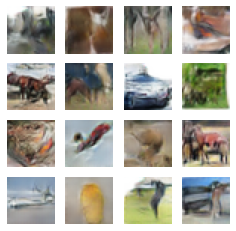

Epoch 60 | iter 1
Time for epoch 60 : 3 sec


KeyboardInterrupt: 

In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

> 레이어를 추가시키고 파라미터를 증가시켜서 학습했는데 60epoch에 5시간이나 걸려서 중단했다 <br>
파라미터 개수가 너무 많아서 그런건지.. 시간을 너무 많이 썼다

### <font color="blue">(8) 활성화 함수 변경</font>
- 노드에 있는 기본 모델에서 generator model의 활성화 함수를 Relu로 변경하고 learning rate를 0.0002로 바꾸었다

In [9]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [10]:
# 생성자 모델 요약
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
re_lu (ReLU)                 (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 128)         0

In [11]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [12]:
# 모델 요약
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [18]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [26]:
save_every = 5
EPOCHS = 300

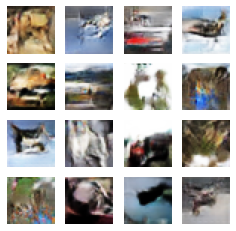

Time for training : 6427 sec


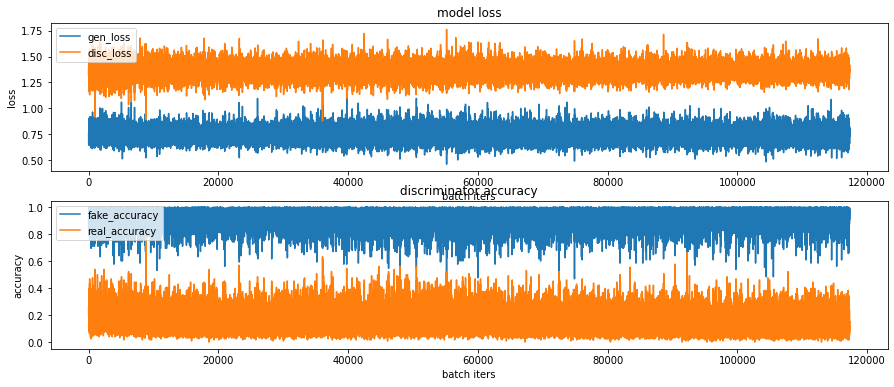

CPU times: user 1h 53min 10s, sys: 11min 48s, total: 2h 4min 58s
Wall time: 1h 47min 14s


In [27]:
%%time
train(train_dataset, EPOCHS, save_every)

> 이미지들이 알아볼 수 있는게 많아진것 같다 <br>
누가봐도 '배' 라고 알 수 있는 이미지가 생성되었다!!! <br>
9번째 이미지도 잘 보면 강아지처럼 생겼다

### <font color="blue">(9) 관련 글 참고</font>
- https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
- 위의 글에 나온 모델과 같게 만들어보았다

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()


    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((4, 4, 256)))

    model.add(layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2D(3, kernel_size=(3,3), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [11]:
# 생성자 모델 요약
generator = make_generator_model()

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              409600    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 128)       262144    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)      

In [12]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))

    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [13]:
# 모델 요약
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)        

In [19]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [26]:
save_every = 5
EPOCHS = 200

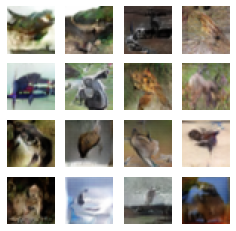

Time for training : 9825 sec


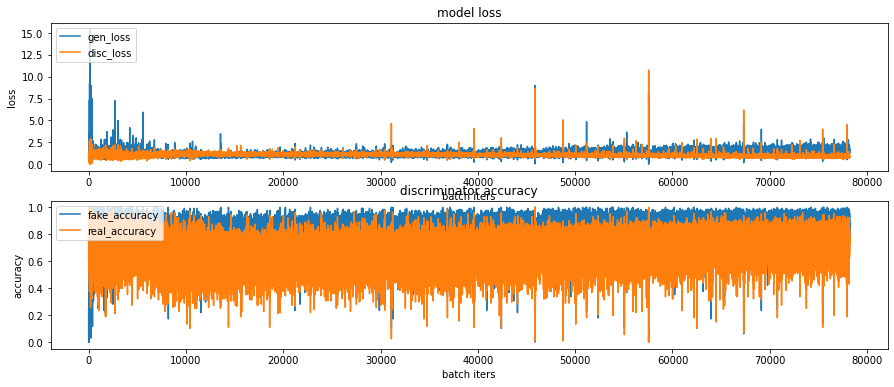

CPU times: user 2h 48min 44s, sys: 8min 16s, total: 2h 57min 1s
Wall time: 2h 43min 50s


In [27]:
%%time
train(train_dataset, EPOCHS, save_every)

> 글을 보면 이미지가 뚜렷하게 구분이 갔는데 모델을 좀 다르게 만든건지 내 이미지는 정확히 알 수가 없다 <br>
그래도 5번 사진은 비행기같은 느낌이 들고 나머지는 동물인 것 같은 느낌이 든다

---

## 정리

### 1.

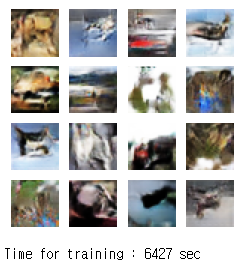

- 위의 이미지가 시도했던 것들 중에서 가장 잘 나온 이미지인것 같다
- 누가 봐도 '배'가 보인다!!!!!!!!!!!! 이미지에 뭐가 보이냐고 물었을 때 '배'인것 같다고 다들 말했다
- 9번째 이미지도 잘 보면 강아지다!!!!!!!!!
- 6번째 이미지도 자동차가 만들어지려고 하는 것 같아 보인다 ㅎㅎ
- 사실 나머지는 잘 모르겠다. 더 돌리면 잘 나올 것 같기도 하다

### 2.
- 이번 노드는 스트레스를 정말 많이 받은 노드다. 여기에 있는 시도들 외에도 많은 시도를 해보았지만 중간에 튕긴 경우들이 너무 많았고 결과가 처참한 것들도 있었다. 많은 시도들을 하려면, 모델을 바꾸려면 많은 공부들이 필요한데 한 모델을 돌리는데 재각각의 많은 시간들이 걸려서 사실 의지가 점점 떨어졌었다. 그래도 정확히 구분할 수 있는 이미지가 하나 생성되어서 뿌듯했다. 이번 프로젝트는 루브릭을 만족하려고 노력하기보다 내가 알아볼 수 있는 이미지 하나만 만들자 라는 마음으로 진행했다. 이번 프로젝트를 통해서 GAN이라는 생성모델을 잘 알게 되었고 그동안 배운 활성화함수, 최적화함수 등 다양하게 적용해볼 수 있었고 더 자세하고 정확하게 공부해야겠다고 다짐하게된 프로젝트다!